In [160]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [271]:
#Reading train and test csv files
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train = train.rename(columns={'KPIs_met >80%': 'kpis_met'})
test = test.rename(columns={'KPIs_met >80%': 'kpis_met'})
train = train.rename(columns={'awards_won?': 'awards_won'})
test = test.rename(columns={'awards_won?': 'awards_won'})

train.dtypes

,0
employee_id,int64
department,object
region,object
education,object
gender,object
recruitment_channel,object
no_of_trainings,int64
age,int64
previous_year_rating,float64
length_of_service,int64


In [162]:
#Checking for null values in all columns
train.isna().sum()[train.isna().sum()>0]


,0
education,2409
previous_year_rating,4124


In [163]:
#Checking null percentage
(train.isna().sum()[train.isna().sum()>0]/train.shape[0]*100).sort_values()

,0
education,4.395344
previous_year_rating,7.524449


<Axes: xlabel='awards_won?', ylabel='Count'>

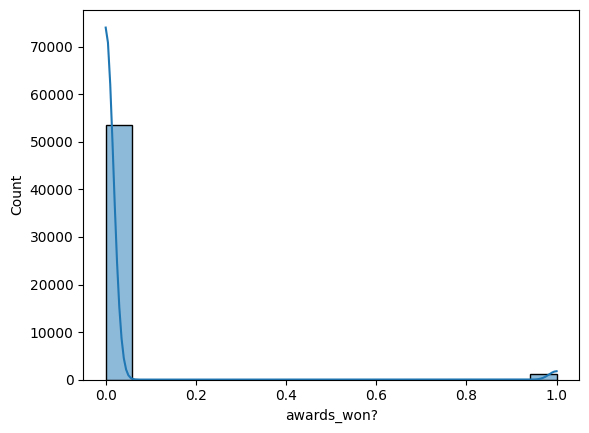

In [164]:
sns.histplot(train['awards_won?'],kde=True)

In [165]:
for col in train.select_dtypes(include='object').columns:
  print(col)

department
region
education
gender
recruitment_channel


In [166]:
for col in train.select_dtypes(exclude = 'object').columns:
  print(col)

employee_id
no_of_trainings
age
previous_year_rating
length_of_service
KPIs_met >80%
awards_won?
avg_training_score
is_promoted


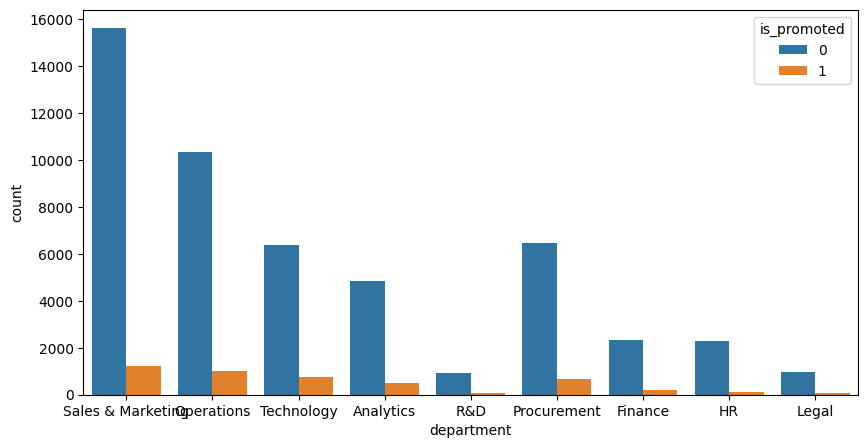

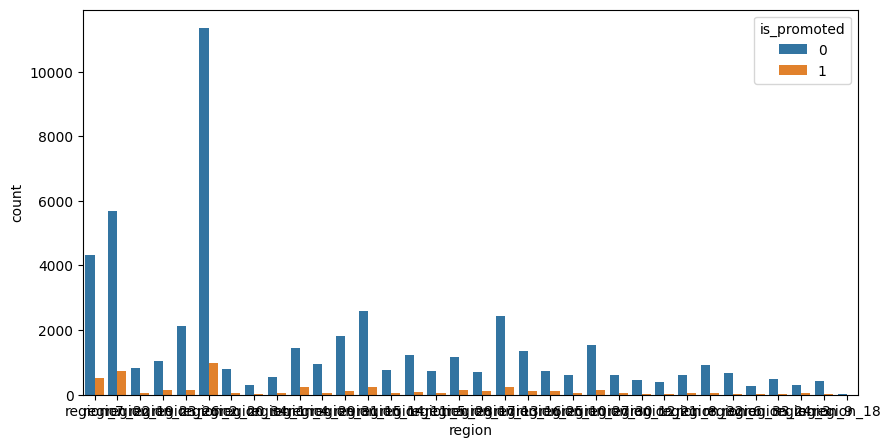

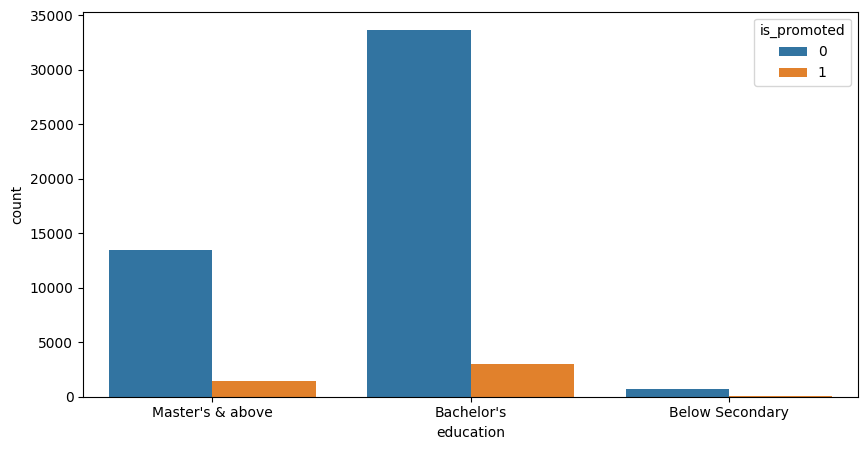

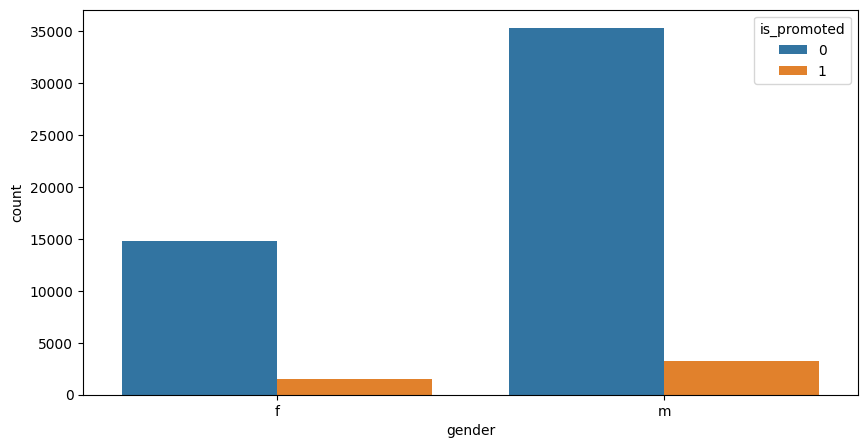

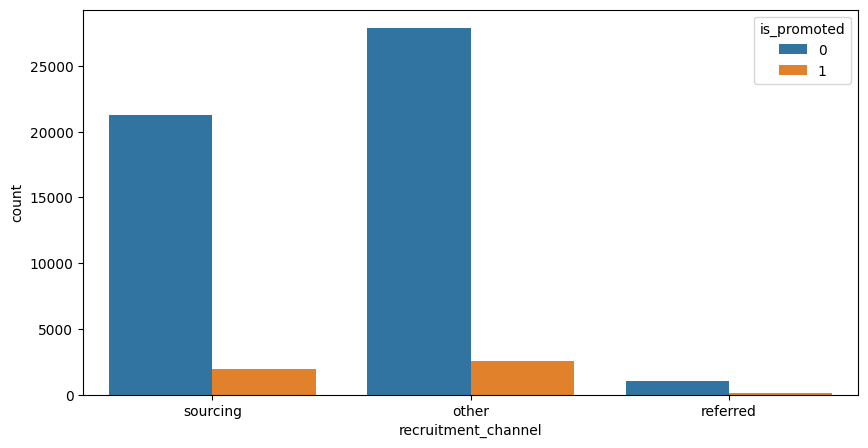

In [167]:
#plotting countplot to find the count of observation who is getting promoted
for col in train.select_dtypes(include='object').columns:
  plt.figure(figsize=(10,5))
  sns.countplot(x=col,data=train,hue='is_promoted')
  plt.show()


#Higher no.of emp got promoted from categorical data analysis
#Sales & Marketing and Operations
#Region2
#Bachelor degree holder
#Male

<Axes: ylabel='avg_training_score'>

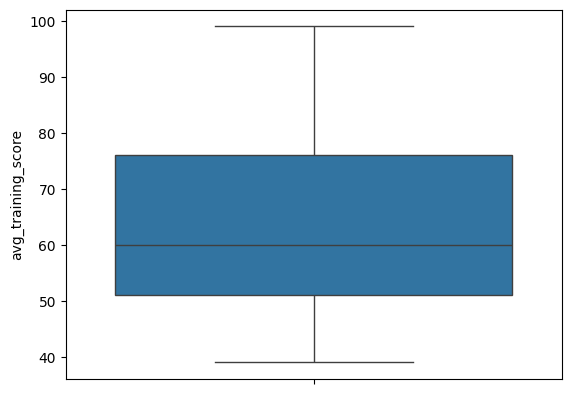

In [168]:
#boxplot to visualize outliers
sns.boxplot(train['avg_training_score'])

#age 55-60 - Not an outlier the retirement age might be 60
#previous year rating 1 - May be poor performance
#length_of_service   above 35 - not an outlier since the retirement age is 60

#Strong relation ship between length of service and age
#Weak relation ship between avg_training_score ( age and length of service)
#weak relation ship between is_promoted and kpi_met>80%

#Preprocessing
#1) Region column - removing region_ and populating the column with region number
#2) Education column - filling the null value with mode
#3) Education column - harcoding "M" for masters  "B" bachelers "S" secondary
#4) Previous year rating - filling the null value with 1 because they may be joined newly

In [169]:
for df in [train, test]:
    # Standardize labels
    df['education'].replace({"Master's & above": "M","Bachelor's": "B","Below Secondary": "S"}, inplace=True)
    # Fill missing
    df['education'].fillna(df['education'].mode()[0], inplace=True) #Global Mode fix
    df['previous_year_rating'].fillna(0, inplace=True)
    df['region'] = df['region'].str[7:]


In [170]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [171]:
num_col = ['no_of_trainings','age', 'previous_year_rating','length_of_service', 'kpis_met', 'awards_won','avg_training_score']
catg_col =['department','education','gender','region','recruitment_channel']
catg_col

['department', 'education', 'gender', 'region', 'recruitment_channel']

In [172]:
#for categorical columns imputing the mode value to null and onehotencoder to convert categorical to numerical data
catg_pipe_enc = Pipeline(steps = [('imputer',SimpleImputer(strategy ='most_frequent')),('ohe',OneHotEncoder(handle_unknown ='ignore',drop='first'))])

In [173]:
#numerical column replace null with mean value and standardising the scales
num_pipe_enc = Pipeline(steps= [('imputer',SimpleImputer(strategy='mean')),('scaler',StandardScaler())])

In [174]:
preprocess = ColumnTransformer(transformers=[('cat_enc',catg_pipe_enc, catg_col),('num_enc',num_pipe_enc,num_col)])

In [175]:
from sklearn.linear_model import LogisticRegression

model_pipeline = Pipeline(steps=[('preprocess',preprocess),('model',LogisticRegression())])
model_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_enc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['department', 'education',
                                                   'gender', 'region',
                                                   'recruitment_channel']),
                                                 ('num_enc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_trainings', 'age',
                                                   'previous_year_rating',
                                                   'length_of_service',
                                                   'KPIs_met >80%',
                                                   'awards_won?',
                                                   'avg_training_score'])])),
                ('model', LogisticRegression())])

In [176]:
tgt_col1= ['is_promoted']
ign_col1 =['employee_id']

X = train.drop(columns=ign_col1+tgt_col1)
y = train['is_promoted']


In [177]:
from sklearn.model_selection import train_test_split
# 90% traindata, 10%valdata
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.1, random_state=42)
train_X.shape, val_X.shape, train_y.shape, val_y.shape
train_y.value_counts(), val_y.value_counts()


(is_promoted
 0    45090
 1     4237
 Name: count, dtype: int64,
 is_promoted
 0    5050
 1     431
 Name: count, dtype: int64)

In [178]:
#fit the model
model_pipeline.fit(train_X, train_y)
model_pipeline.predict(val_X)
#model_pipeline.predict_proba(val_X)


array([0, 0, 0, ..., 0, 0, 0])

In [179]:
from sklearn.metrics import roc_auc_score

def model_train_cal_eval(train_X, train_y, val_X, val_y, model_pipeline):
  predicted_train_tgt = model_pipeline.predict(train_X)
  predicted_val_tgt = model_pipeline.predict(val_X)

  print('Train Score:',roc_auc_score(train_y, predicted_train_tgt))
  print('Val Score:',roc_auc_score(val_y, predicted_val_tgt))

In [180]:
model_train_cal_eval(train_X, train_y, val_X, val_y, model_pipeline)

sub = pd.read_csv('sample_submission.csv')
sub.head()

sub['is_promoted'] = model_pipeline.predict(test.drop(columns=ign_col1))
sub.to_csv('sub1_logreg_imb.csv',index=False)


Train Score: 0.6225531105465361
Val Score: 0.6251349612919529


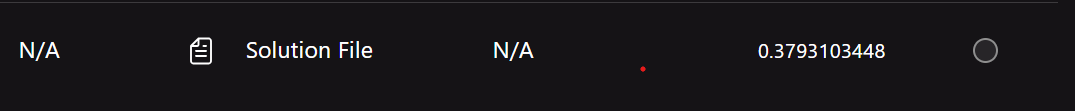

In [181]:
df1 = pd.read_csv('sub1_logreg_imb.csv')
df1.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [182]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV


In [252]:
param_1 = [
    {
        'model' : [LogisticRegression()],
        'model__penalty' : ['l2',None, 'l1','elasticnet'],
        'model__C' : [0.5, 3],
        'model__class_weight': ['balanced']

    },
    {
        'model' : [DecisionTreeClassifier()],
        'model__max_depth' : [3, 5],
        'model__class_weight': ['balanced'],
        'model__max_depth' : [3, 5, 7, 10],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 5],
        'model__max_features': ["sqrt", "log2"]

    }
]


In [254]:
grid_1 = GridSearchCV(estimator=model_pipeline, param_grid=param_1, cv=5,scoring='roc_auc')
grid_1

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_enc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['department',
                                                                          'education',
                                                                          'gender',
                                                                          'region',
                                                                          'recruitment_channel']),
                                                                        ('num_enc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer...
             param_grid=[{'model': [LogisticRegression()], 'model__C': [0.5, 3],
                          'model__class_weight': ['balanced'],
                          'model__penalty': ['l2', None, 'l1', 'elasticnet']},
                         {'model': [DecisionTreeClassifier()],
                          'model__class_weight': ['balanced'],
                          'model__max_depth': [3, 5, 7, 10],
                          'model__max_features': ['sqrt', 'log2'],
                          'model__min_samples_leaf': [1, 2, 5],
                          'model__min_samples_split': [2, 5, 10]}],
             scoring='roc_auc')

In [247]:
#Over Sampling

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
over_sampling = RandomOverSampler()
under_sampling = RandomUnderSampler()
train_X.shape, train_y.shape
train_y.value_counts()


,count
is_promoted,
0,40086
1,3760


In [255]:
train_X_os , train_y_os = over_sampling.fit_resample(train_X, train_y)
train_X_os.shape, train_y_os.shape
train_y_os.value_counts()

grid_1.fit(train_X_os, train_y_os)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_enc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['department',
                                                                          'education',
                                                                          'gender',
                                                                          'region',
                                                                          'recruitment_channel']),
                                                                        ('num_enc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer...
             param_grid=[{'model': [LogisticRegression()], 'model__C': [0.5, 3],
                          'model__class_weight': ['balanced'],
                          'model__penalty': ['l2', None, 'l1', 'elasticnet']},
                         {'model': [DecisionTreeClassifier()],
                          'model__class_weight': ['balanced'],
                          'model__max_depth': [3, 5, 7, 10],
                          'model__max_features': ['sqrt', 'log2'],
                          'model__min_samples_leaf': [1, 2, 5],
                          'model__min_samples_split': [2, 5, 10]}],
             scoring='roc_auc')

In [256]:
grid_1.best_params_


{'model': LogisticRegression(),
 'model__C': 0.5,
 'model__class_weight': 'balanced',
 'model__penalty': None}

In [188]:
grid_1.best_estimator_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_enc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['department', 'education',
                                                   'gender', 'region',
                                                   'recruitment_channel']),
                                                 ('num_enc',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['no_of_trainings', 'age',
                                                   'previous_year_rating',
                                                   'length_of_service',
                                                   'KPIs_met >80%',
                                                   'awards_won?',
                                                   'avg_training_score'])])),
                ('model',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    penalty=None))])

In [257]:
res_df_1 = pd.DataFrame(grid_1.cv_results_)
res_df_1.head(1)
#grid_1.cv_results_.
pd.set_option('display.max_colwidth', 1000)
res_df_1[['param_model','params','mean_test_score','rank_test_score']]


new_model = grid_1.best_estimator_

model_train_cal_eval(train_X_os, train_y_os, val_X, val_y, new_model)

new_model.predict(test.drop(columns=ign_col1))
sub.to_csv('sub2_grid_os.csv',index=False)



Train Score: 0.7919722596417702
Val Score: 0.7969963933748363


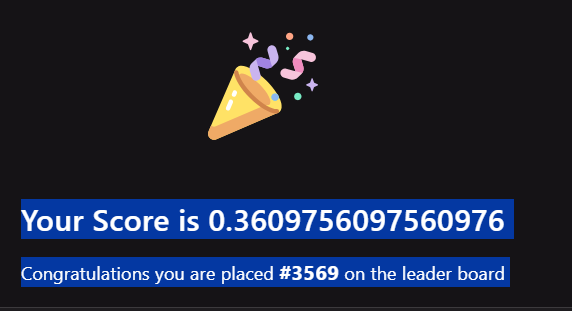

In [196]:
train_X_os , train_y_os = under_sampling.fit_resample(train_X, train_y)
train_X_os.shape, train_y_os.shape
train_y_os.value_counts()

grid_1.fit(train_X_os, train_y_os)


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat_enc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['department',
                                                                          'education',
                                                                          'gender',
                                                                          'region',
                                                                          'recruitment_channel']),
                                                                        ('num_enc',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer...
                                                                          'KPIs_met '
                                                                          '>80%',
                                                                          'awards_won?',
                                                                          'avg_training_score'])])),
                                       ('model', LogisticRegression())]),
             param_grid=[{'model': [LogisticRegression()], 'model__C': [0.5, 3],
                          'model__class_weight': ['balanced'],
                          'model__penalty': ['l2', None, 'l1', 'elasticnet']},
                         {'model': [DecisionTreeClassifier()],
                          'model__class_weight': ['balanced'],
                          'model__max_depth': [3, 5]}],
             scoring='roc_auc')

In [197]:
res_df_2 = pd.DataFrame(grid_1.cv_results_)
res_df_2.head(1)
#grid_1.cv_results_.
pd.set_option('display.max_colwidth', 1000)
res_df_2[['param_model','params','mean_test_score','rank_test_score']]


new_model = grid_1.best_estimator_

model_train_cal_eval(train_X_os, train_y_os, val_X, val_y, new_model)

new_model.predict(test.drop(columns=ign_col1))
sub.to_csv('sub2_grid_under_os.csv',index=False)



Train Score: 0.7995043662969082
Val Score: 0.7945491718545404


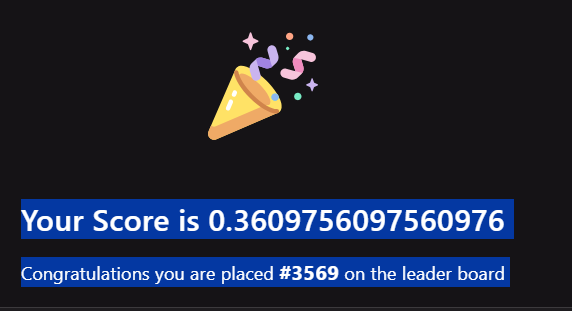

In [198]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [268]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size =0.2,random_state=24)

# Create a pipeline for the Decision Tree Classifier, including the preprocessing steps
model_pipeline_dt = Pipeline(steps=[('preprocess',preprocess),('model',DecisionTreeClassifier(
))])

# Fit the pipeline on the training data
model_pipeline_dt.fit(train_X,train_y)

# Make predictions using the fitted pipeline
train_predictionsdt = model_pipeline_dt.predict(train_X)
test_predictionsdt = model_pipeline_dt.predict(test_X)

print("Training Accuracy: ", accuracy_score(train_y,train_predictionsdt))
print("Testing Accuracy: ", accuracy_score(test_y,test_predictionsdt))

print("Training Report: ", classification_report(train_y,train_predictionsdt))
print("Testing Report: ", classification_report(test_y,test_predictionsdt))

print("Confusion Matrix Train:", confusion_matrix(train_y,train_predictionsdt))
print("Confusion Matrix Test:", confusion_matrix(test_y,test_predictionsdt))

Training Accuracy:  0.9998403503170187
Testing Accuracy:  0.9046706805327495
Training Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       1.00      1.00      1.00      3760

    accuracy                           1.00     43846
   macro avg       1.00      1.00      1.00     43846
weighted avg       1.00      1.00      1.00     43846

Testing Report:                precision    recall  f1-score   support

           0       0.95      0.95      0.95     10054
           1       0.43      0.45      0.44       908

    accuracy                           0.90     10962
   macro avg       0.69      0.70      0.69     10962
weighted avg       0.91      0.90      0.91     10962

Confusion Matrix Train: [[40086     0]
 [    7  3753]]
Confusion Matrix Test: [[9504  550]
 [ 495  413]]


In [269]:
model_train_cal_eval(train_X, train_y, test_X, test_y, model_pipeline_dt)

subdt = pd.read_csv('sample_submission.csv')
subdt.head()

subdt['is_promoted'] = model_pipeline_dt.predict(test.drop(columns=ign_col1))
subdt.to_csv('sub_dt_imb.csv',index=False)


Train Score: 0.9990691489361703
Val Score: 0.7000706098959889


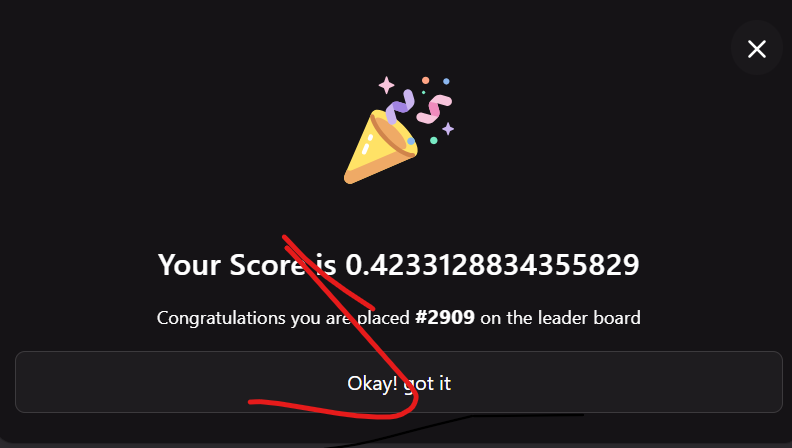

In [207]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size =0.2,random_state=24)

# Create a pipeline for the Decision Tree Classifier, including the preprocessing steps
model_pipeline_RF = Pipeline(steps=[('preprocess',preprocess),('model',RandomForestClassifier())])

# Fit the pipeline on the training data
model_pipeline_RF.fit(train_X,train_y)

# Make predictions using the fitted pipeline
train_predictionsRF = model_pipeline_RF.predict(train_X)
test_predictionsRF = model_pipeline_RF.predict(test_X)

print("Training Accuracy: ", accuracy_score(train_y,train_predictionsRF))
print("Testing Accuracy: ", accuracy_score(test_y,test_predictionsRF))

print("Training Report: ", classification_report(train_y,train_predictionsRF))
print("Testing Report: ", classification_report(test_y,test_predictionsRF))

print("Confusion Matrix Train:", confusion_matrix(train_y,train_predictionsRF))
print("Confusion Matrix Test:", confusion_matrix(test_y,test_predictionsRF))

Training Accuracy:  0.9997947361218811
Testing Accuracy:  0.9385148695493523
Training Report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00     40086
           1       1.00      1.00      1.00      3760

    accuracy                           1.00     43846
   macro avg       1.00      1.00      1.00     43846
weighted avg       1.00      1.00      1.00     43846

Testing Report:                precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.87      0.31      0.45       908

    accuracy                           0.94     10962
   macro avg       0.90      0.65      0.71     10962
weighted avg       0.93      0.94      0.92     10962

Confusion Matrix Train: [[40085     1]
 [    8  3752]]
Confusion Matrix Test: [[10011    43]
 [  631   277]]


In [208]:
model_train_cal_eval(train_X, train_y, val_X, val_y, model_pipeline_RF)

subrf = pd.read_csv('sample_submission.csv')
subrf.head()

subrf['is_promoted'] = model_pipeline_RF.predict(test.drop(columns=ign_col1))
subrf.to_csv('sub1_rf_imb.csv',index=False)



Train Score: 0.9989236970301086
Val Score: 0.9240989180124509


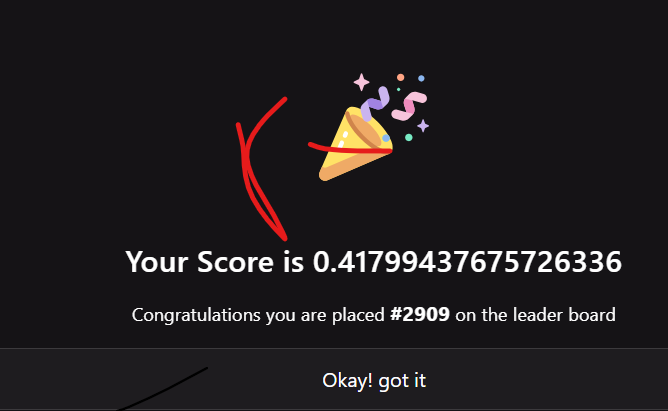

In [209]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size =0.2,random_state=24)

# Create a pipeline for the Decision Tree Classifier, including the preprocessing steps
model_pipeline_AB = Pipeline(steps=[('preprocess',preprocess),('model',AdaBoostClassifier(n_estimators = 100,learning_rate = 0.5))])

# Fit the pipeline on the training data
model_pipeline_AB.fit(train_X,train_y)

# Make predictions using the fitted pipeline
train_predictionsAB = model_pipeline_AB.predict(train_X)
test_predictionsAB = model_pipeline_AB.predict(test_X)

print("Training Accuracy: ", accuracy_score(train_y,train_predictionsAB))
print("Testing Accuracy: ", accuracy_score(test_y,test_predictionsAB))

print("Training Report: ", classification_report(train_y,train_predictionsAB))
print("Testing Report: ", classification_report(test_y,test_predictionsAB))

print("Confusion Matrix Train:", confusion_matrix(train_y,train_predictionsAB))
print("Confusion Matrix Test:", confusion_matrix(test_y,test_predictionsAB))

Training Accuracy:  0.9226839392418921
Testing Accuracy:  0.9262908228425469
Training Report:                precision    recall  f1-score   support

           0       0.92      1.00      0.96     40086
           1       0.86      0.12      0.21      3760

    accuracy                           0.92     43846
   macro avg       0.89      0.56      0.58     43846
weighted avg       0.92      0.92      0.89     43846

Testing Report:                precision    recall  f1-score   support

           0       0.93      1.00      0.96     10054
           1       0.88      0.13      0.22       908

    accuracy                           0.93     10962
   macro avg       0.91      0.56      0.59     10962
weighted avg       0.92      0.93      0.90     10962

Confusion Matrix Train: [[40011    75]
 [ 3315   445]]
Confusion Matrix Test: [[10039    15]
 [  793   115]]


In [210]:
model_train_cal_eval(train_X, train_y, val_X, val_y, model_pipeline_AB)

subab = pd.read_csv('sample_submission.csv')
subab.head()

subab['is_promoted'] = model_pipeline_AB.predict(test.drop(columns=ign_col1))
subab.to_csv('sub1_ada_imb.csv',index=False)

Train Score: 0.5582400432155972
Val Score: 0.5733548505662631


ADA Booster, Random forest Training and Testing score is comparatively less than Decision Tree classifier hence for this Hr Analytics Decision tree classifier has given highest rate comparing all other algorithms hence going with Decision tree  prediction

In [230]:
#Streamlit

!pip install joblib
joblib.dump(new_model, 'job_change_pipeline_model.pkl')

['job_change_pipeline_model.pkl']

In [231]:
!pip install streamlit #to create web application

In [242]:
%%writefile webview.py
import  streamlit as st
import pandas as pd
import joblib
df = pd.read_csv("/content/train.csv")
st.title("HR Analytics Prediction")

employee_id = st.number_input("employee_id")
department = st.selectbox("department", pd.unique(df["department"]))
region = st.selectbox("region", pd.unique(df["region"]))
education = st.selectbox("education", pd.unique(df["education"]))
gender = st.selectbox("gender", pd.unique(df["gender"]))
recruitment_channel = st.selectbox("recruitment_channel", pd.unique(df["recruitment_channel"]))
no_of_trainings = st.number_input("no_of_trainings")
age = st.number_input("age")
previous_year_rating = st.selectbox("previous_year_rating", pd.unique(df["previous_year_rating"]))
length_of_service = st.number_input("length_of_service")
KPIs_met = st.selectbox("kpis_met", pd.unique(df["kpis_met"]))
awards_won = st.selectbox("awards_won", pd.unique(df["awards_won"]))
avg_training_score = st.number_input("avg_training_score")

inputs = {
    "employee_id" :employee_id,
    "department": department,
    "region": region,
    "education": education,
    "gender": gender,
    "recruitment_channel": recruitment_channel,
    "no_of_trainings": no_of_trainings,
    "age": age,
    "previous_year_rating": previous_year_rating,
    "length_of_service": length_of_service,
    "kpis_met": KPIs_met,
    "awards_won": awards_won,
    "avg_training_score": avg_training_score
}

if st.button("Predict"):
  model = joblib.load('job_change_pipeline_model.pkl')
  X_input = pd.DataFrame([inputs])
  prediction = model.predict(X_input)
  st.write(prediction)



Overwriting webview.py


In [233]:
#step-1
#https://dashboard.ngrok.com/get-started/your-authtoken
!pip install pyngrok

In [234]:
!ngrok authtoken 378kbcxJfiwn1bekYYGXckQiLuM_6tgf6fy8qD7pVTRuwTsMB

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [243]:
!streamlit run webview.py & ngrok http 8501 --log stdout


INFO[01-04|10:44:48] no configuration paths supplied 
INFO[01-04|10:44:48] using configuration at default config path path=/root/.config/ngrok/ngrok.yml
INFO[01-04|10:44:48] open config file                         path=/root/.config/ngrok/ngrok.yml err=nil
t=2026-01-04T10:44:48+0000 lvl=info msg="FIPS 140 mode" enabled=false
t=2026-01-04T10:44:48+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
t=2026-01-04T10:44:48+0000 lvl=info msg="client session established" obj=tunnels.session
t=2026-01-04T10:44:48+0000 lvl=info msg="tunnel session started" obj=tunnels.session
t=2026-01-04T10:44:48+0000 lvl=info msg="started tunnel" obj=tunnels name=command_line addr=http://localhost:8501 url=https://stutteringly-unnamed-ilene.ngrok-free.dev


t=2026-01-04T10:44:49+0000 lvl=warn msg="failed to open private leg" id=d8f45661e9ae privaddr=localhost:8501 err="dial tcp [::1]:8501: connect: connection refused"
t=2026-01-04T10:44:49+0000 lvl=warn msg="failed to open pr

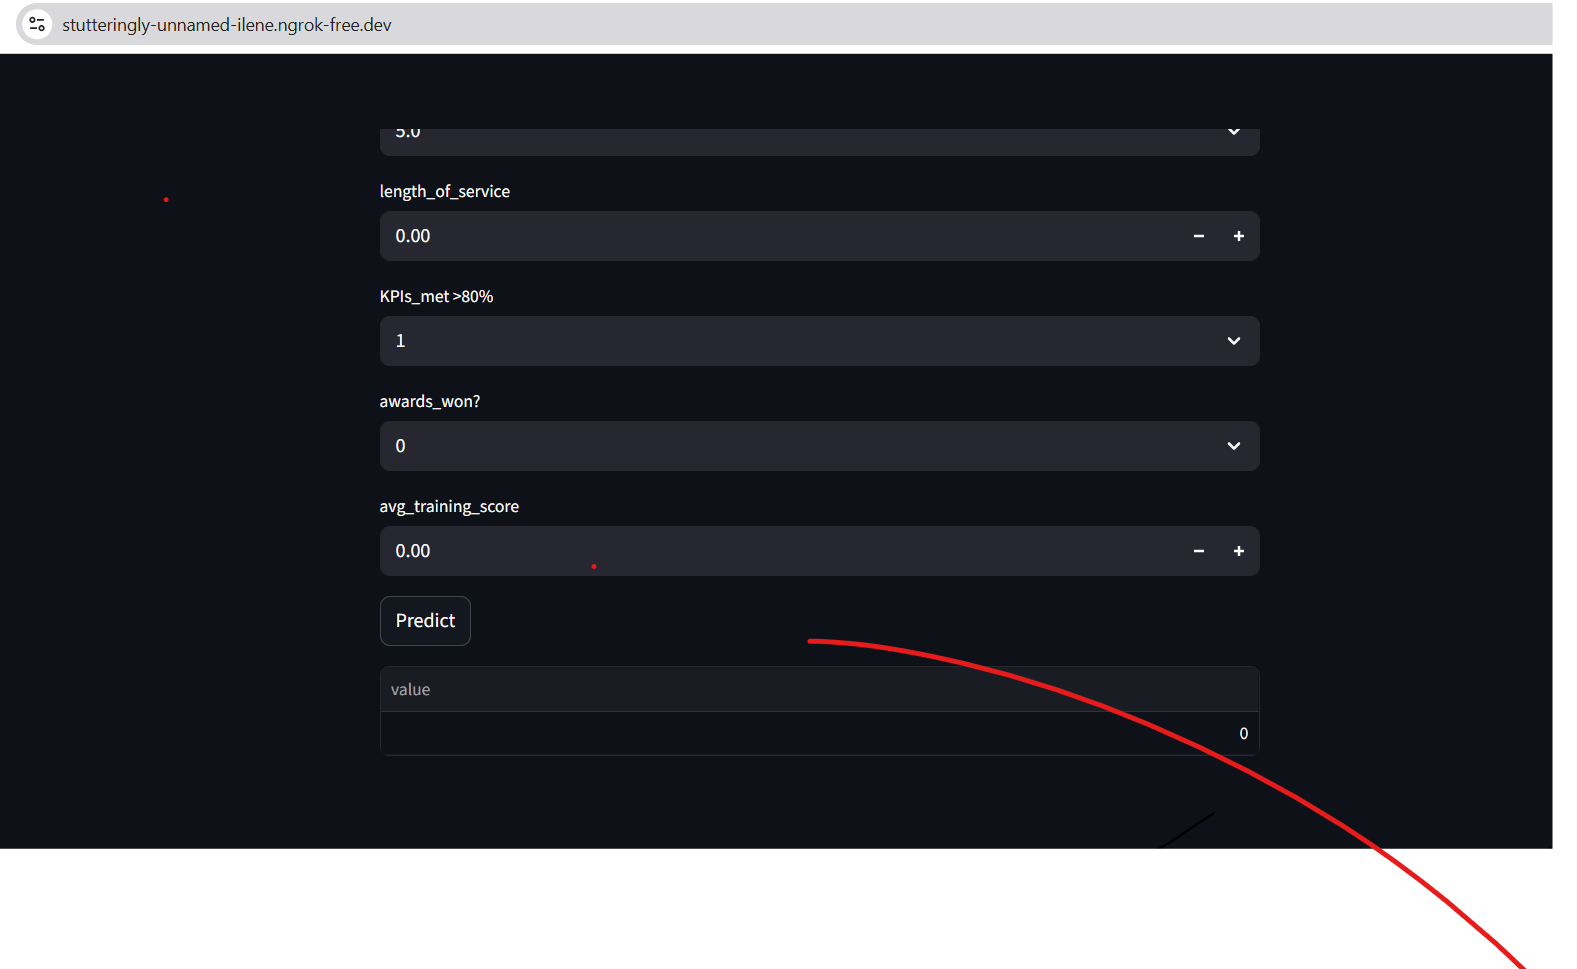

In [272]:
%%writefile app.py

from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import pandas as pd

app = FastAPI()

class Input(BaseModel):
  employee_id : float
  department : object
  region : object
  education :object
  gender : object
  recruitment_channel : object
  no_of_trainings : float
  age : float
  previous_year_rating : float
  length_of_service : float
  KPIs_met : float
  awards_won : float
  avg_training_score : float

class Output(BaseModel):
  target : int

@app.get("/")
def read_root():
  return {"Hello": "World"}

@app.post("/predict")
def predict(data : Input) -> Output:
  model = joblib.load('job_change_pipeline_model.pkl')

  X_input = pd.DataFrame([[data.employee_id, data.department, data.region, data.education,
                          data.gender, data.recruitment_channel, data.no_of_trainings, data.age,
                          data.previous_year_rating, data.length_of_service, data.KPIs_met, data.awards_won,data.avg_training_score]])

  X_input.columns = [ 'employee_id', 'department','region','education', 'gender',
       'recruitment_channel', 'no_of_trainings', 'age',
       'previous_year_rating', 'length_of_service', 'kpis_met', 'awards_won',
       'average_training_score']

  #X_input = pd.DataFrame([Input.dict()])
  prediction = model.predict(X_input)
  print(prediction)
  return Output(target=prediction[0])


Writing app.py


In [273]:
!nohup uvicorn  app:app --host 0.0.0.0 --port 8000 &

nohup: appending output to 'nohup.out'


In [274]:
from google.colab.output import eval_js

print(eval_js("google.colab.kernel.proxyPort(8000)"))

https://8000-m-s-1exgfzfjl9mfk-b.us-central1-1.prod.colab.dev
